<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Naming-conventions" data-toc-modified-id="Naming-conventions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Naming conventions</a></span></li><li><span><a href="#Config" data-toc-modified-id="Config-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Config</a></span></li><li><span><a href="#Load-Standards" data-toc-modified-id="Load-Standards-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load Standards</a></span></li><li><span><a href="#Load-datas" data-toc-modified-id="Load-datas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load datas</a></span><ul class="toc-item"><li><span><a href="#Helper-Functions" data-toc-modified-id="Helper-Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper Functions</a></span></li><li><span><a href="#Animal-emissions" data-toc-modified-id="Animal-emissions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Animal emissions</a></span><ul class="toc-item"><li><span><a href="#Tables-description" data-toc-modified-id="Tables-description-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Tables description</a></span></li><li><span><a href="#Enteric-Fermentation" data-toc-modified-id="Enteric-Fermentation-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Enteric Fermentation</a></span><ul class="toc-item"><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.2.1"><span class="toc-item-num">4.2.2.1&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-Column" data-toc-modified-id="Item-Column-4.2.2.2"><span class="toc-item-num">4.2.2.2&nbsp;&nbsp;</span>Item Column</a></span></li></ul></li><li><span><a href="#Manure-Soils" data-toc-modified-id="Manure-Soils-4.2.3"><span class="toc-item-num">4.2.3&nbsp;&nbsp;</span>Manure Soils</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.3.1"><span class="toc-item-num">4.2.3.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.3.2"><span class="toc-item-num">4.2.3.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals" data-toc-modified-id="Item-column-:-Removing-groups-of-animals-4.2.3.3"><span class="toc-item-num">4.2.3.3&nbsp;&nbsp;</span>Item column : Removing groups of animals</a></span></li></ul></li><li><span><a href="#Manure-Pasture" data-toc-modified-id="Manure-Pasture-4.2.4"><span class="toc-item-num">4.2.4&nbsp;&nbsp;</span>Manure Pasture</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.4.1"><span class="toc-item-num">4.2.4.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-column" data-toc-modified-id="Element-column-4.2.4.2"><span class="toc-item-num">4.2.4.2&nbsp;&nbsp;</span>Element column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals" data-toc-modified-id="Item-column-:-Removing-groups-of-animals-4.2.4.3"><span class="toc-item-num">4.2.4.3&nbsp;&nbsp;</span>Item column : Removing groups of animals</a></span></li></ul></li><li><span><a href="#Manure-Management" data-toc-modified-id="Manure-Management-4.2.5"><span class="toc-item-num">4.2.5&nbsp;&nbsp;</span>Manure Management</a></span><ul class="toc-item"><li><span><a href="#Checking-for-null-values" data-toc-modified-id="Checking-for-null-values-4.2.5.1"><span class="toc-item-num">4.2.5.1&nbsp;&nbsp;</span>Checking for null values</a></span></li><li><span><a href="#Element-Column" data-toc-modified-id="Element-Column-4.2.5.2"><span class="toc-item-num">4.2.5.2&nbsp;&nbsp;</span>Element Column</a></span></li><li><span><a href="#Item-column-:-Removing-groups-of-animals:" data-toc-modified-id="Item-column-:-Removing-groups-of-animals:-4.2.5.3"><span class="toc-item-num">4.2.5.3&nbsp;&nbsp;</span>Item column : Removing groups of animals:</a></span></li></ul></li></ul></li><li><span><a href="#Computed-emissions-data" data-toc-modified-id="Computed-emissions-data-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Computed emissions data</a></span></li><li><span><a href="#Productions" data-toc-modified-id="Productions-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Productions</a></span></li><li><span><a href="#Trade-data" data-toc-modified-id="Trade-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Trade data</a></span></li></ul></li><li><span><a href="#Livestock-food-estimate" data-toc-modified-id="Livestock-food-estimate-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Livestock food estimate</a></span><ul class="toc-item"><li><span><a href="#Beef" data-toc-modified-id="Beef-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Beef</a></span></li><li><span><a href="#Dairy-cattle" data-toc-modified-id="Dairy-cattle-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Dairy cattle</a></span></li><li><span><a href="#Poultry" data-toc-modified-id="Poultry-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Poultry</a></span></li><li><span><a href="#Poultry-(laying-hen)" data-toc-modified-id="Poultry-(laying-hen)-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Poultry (laying hen)</a></span></li><li><span><a href="#Swine" data-toc-modified-id="Swine-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Swine</a></span></li></ul></li></ul></div>

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotmap import DotMap
from pathlib import Path
from collections.abc import Mapping, Iterable

from IPython.display import display

%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Naming conventions

For easier reading, the following naming conventions are used. The templates are written as shell file template

+ `df_*` denotes an pandas.DataFrame
+ `dfs_*` denotes any dict-like mapping from names to pandas.DataFrame

Those naming conventions also holds for helper function signatures

# Config

In [2]:
DATA = Path("./data")

# Load Standards

Flags provide additional info on how the values in datasets where obtained

In [3]:
df_flags = pd.read_csv(
    DATA / "definitions_and_standards/flags.csv",
    keep_default_na=False,
    index_col="Flag"
)

The same country code are used in all of FAOSTAT datasets. As datasets contains aggregated data on country groups, loading that dataframe will allow to remove aggregated data.

In [4]:
df_area_groups = pd.read_csv(
    DATA / "definitions_and_standards/country_group.csv"
)

# Load datas

## Helper Functions

In [5]:
# Helper function

#snake case conversion
_first_cap_re = re.compile("(\w)([A-Z][a-z]+)")
_all_cap_re = re.compile("([a-z0-9])([A-Z])")
_space_between = re.compile("(\W*) ([a-z]*)")


def to_snakecase(name):
    s1 = _first_cap_re.sub(r"\1_\2", name)
    s2 = _all_cap_re.sub(r"\1_\2", s1).lower()
    s3 = _space_between.sub(r"\1_\2", s2)
    return s3.replace(" ", "").replace("__", "_")

def join_flags(df, filepath, df_flags):
    df["Flag"] = pd.read_csv(filepath, encoding="latin1", usecols=["Flag"], keep_default_na=False)
    return df.merge(df_flags, on="Flag").drop(columns="Flag").rename(columns={"Flags": "Flag"})

def load_df(filepath, join_df_flags=None, encoding="latin1"):
    """
    Function for quick loading of dataframes. Use the correct encoding and reloads the Flags column
    if th dataframe of the flags is provided
    """
    df = pd.read_csv(filepath, encoding=encoding)
    if join_df_flags is not None:
        df = join_flags(df, filepath, join_df_flags)
    return df

def split_on(df, column, rename={}, only_named=False, drop=[]):
    """
    Splits a dataframe in multiple dataframe based on the value of a columne
    
    Args:
        df: dataframe to spli
        column: name of the column to split on
        rename (optional): mapping or callable that rename values to name in the final dictionary
        only_named (False): keep only dataframe with a value in column that is renamed
        drop: drop columns in resulting dataframes (useful for redundant columns)
    
    Returns:
        A dictionnary mapping unique values in df[column] to the dataframe with that value.
        Value (i.e. dict keys) can be renamed by the rename argument. A callable can return None to not rename it.
    """
    result = DotMap(_dynamic=False)
    if not isinstance(drop, Iterable) or isinstance(drop, str):
        drop = [drop]
    for value in df[column].unique():
        if callable(rename):
            name = rename(value)
        elif isinstance(rename, Mapping):
            name = rename.get(value)
        else:
            name = None
        if name is None and only_named:
            continue
        result[name or value] = df[ df[column] == value].drop(columns=drop + [column])
    return result

def select_on(df, column_filter_dict):
    """
    Filter some columns of the DataFrame for values in the provided list. Equivalent to as sequence
    of isin() calls
    
    Args:
        df: the dataframe to filter
        column_value_filter_dict: a mapping from column names to the list of value to keep
    
    Returns:
        The filtered dataframe
    """
    for column, values in column_filter_dict.items():
        df = df[ df[column].isin(values) ]
    return df


def remove_country_group(df, df_area_code=None):
    """
    Remove all entries in the DataFrame for group of countries (e.g. Asia)

    Args:
        df: the DataFrame to filter
        df_area_code: dataframe from the standards, indicating which countries are in which country group
            If not provided, defaults to removing Area Code >= 5000 (see note)
    
    Returns:
        A filtered DataFrame
    
    Note:
        It appears all country-group use "Area Code" >= 5000.
        However, this is not guaranteed so we prefere to use the standars to get country group code
    """
    if df_area_code is not None:
        return df[~df["Area Code"].isin(df_area_code["Country Group Code"])]
    else:
        return df[ df["Area Code"] < 5000]

def plot_completeness_histogram(df_or_dfs, ax=None, figsize=None, agg_on="Area Code"):
    """
    Plot the histogram of how many unique area_code provide data for each year. Used
    to get an idea on how complete the data are


    Args:
        df_or_dfs: the dataframe to plot the completeness histogram of
            OR a mapping from names to dataframes
        ax: matplotlib Axis to draw on
    Returns:
        None. Plot the afformention histogram
    """
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    if isinstance(df_or_dfs, Mapping):
        pd.DataFrame(
            {
                name: df.groupby("Year")[agg_on].nunique()
                for name, df in df_or_dfs.items()
            }
        ).plot.bar(ax=ax)
        ax.legend()
    else:
        df_or_dfs.groupby("Year")[agg_on].nunique().plot.bar(ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel("# of countries with available data")
    ax.set_title("Evolution of data completeness")
    return ax

## Animal emissions

Load necessary dataframes and join with the flags dataframe. The "Year Code" column is redundant with the "Year" column, so we drop it

In [6]:
df_enteric_fermentation = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Enteric_Fermentation_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_soils = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_applied_to_soils_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_management = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_Management_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

df_manure_pasture = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Emissions_Agriculture_Manure_left_on_pasture_E_All_Data_(Norm).csv",
    df_flags
).drop(columns="Year Code")

### Tables description

Each of the 4 tables have the same columns, which are described below:

In [7]:
df_enteric_fermentation.columns

Index(['Country Code', 'Country', 'Item Code', 'Item', 'Element Code',
       'Element', 'Year', 'Unit', 'Value', 'Flag'],
      dtype='object')


- **Country code**: unique identifier of countries
- **Country**
- **Item**: Animal
- **Item Code**: unique identifier of Animal
- **Element**: type of GHG(Greenhouse gaz) emission / Stock
- **Element Code**: unique identifier of the type of emission
- **Year**
- **Unit**: Unit of Element
- **Value**: Value of Element
- **Flag**: Origin of the data
 


For each of these 4 tables we will start by cleaning and preprocessing the data, then do a quick analysis of the livestock species(asses, buffaloes, camels...) to see the animals that produce the most emissions in the world first by the total number of livestock species then only by head. 

### Enteric Fermentation
The table ‘Enteric Fermentation’ contains the following data:
country-level GHG(Greenhouse gaz) emissions in both Gg CH4 and Gg CO2eq, by animal categories and their aggregates, as well as their total; implied emission factors; and activity data.

In [8]:
df_enteric_fermentation.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


In [9]:
df_enteric_fermentation.isna().any()

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value           False
Flag            False
dtype: bool

No null values in this table

In [10]:
print("Unique years :\n",df_enteric_fermentation["Year"].unique())
print()
print("Unique flags :\n",df_enteric_fermentation["Flag"].unique())

Unique years :
 [1961 1962 1963 1965 1966 1967 1968 1969 1970 1971 1972 1977 1987 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 1978 1979 1980 1981 1982 1986 1973 1974 1975 1976 1995 1998 1991
 1997 1988 1989 1990 1964 1992 1993 1994 1996 1985 1983 1984 2030 2050]

Unique flags :
 ['Official data' 'FAO estimate' 'Unofficial figure' 'Calculated data'
 'Aggregate, may include official, semi-official, estimated or calculated data'
 'FAO data based on imputation methodology']


In [11]:
#Removing predictions of future years
df_enteric_fermentation = df_enteric_fermentation[df_enteric_fermentation["Year"] < 2030]

#Description of Element column
df_enteric_fermentation["Element"].unique()

array(['Stocks', 'Implied emission factor for CH4 (Enteric)',
       'Emissions (CH4) (Enteric)', 'Emissions (CO2eq) (Enteric)'],
      dtype=object)

In the *Element* column we will only be interested in the value of *Stocks* which corresponds to the total number of livestock species(asses, buffaloes, camels...) and the value of *Emissions (CO2eq) (Enteric)* which corresponds to the total aggregate of the GHG emission in CO2eq

#### Element Column 

In [12]:
#Filter the Element Column
dfs_enteric_fermentation = split_on(
    df_enteric_fermentation[
        df_enteric_fermentation["Element"].isin(["Stocks","Emissions (CO2eq) (Enteric)"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Enteric)": "emissions"
    }
)

print("Stock unit :", dfs_enteric_fermentation.stocks["Unit"].unique())
print("Emission unit :", dfs_enteric_fermentation.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item Column

The Item column contains all the livestock species as well as some groups of animals, we will filter those and only keep the different animals


In [13]:
print(df_enteric_fermentation["Item"].unique())

Animals = ['Asses', 'Buffaloes', 'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Goats', 'Horses','Llamas', 'Mules','Sheep','Swine']

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_enteric_fermentation_filtered = DotMap(_dynamic=False)
dfs_enteric_fermentation_filtered["stocks"] = select_on(
    dfs_enteric_fermentation.stocks,
    column_filter_dict=column_filters
)

dfs_enteric_fermentation_filtered["emissions"] = select_on(
    dfs_enteric_fermentation.emissions,
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes'
 'Cattle, dairy' 'Cattle, non-dairy' 'Swine, breeding' 'Swine, market'
 'Llamas' 'All Animals' 'Camels and Llamas' 'Cattle' 'Mules and Asses'
 'Sheep and Goats' 'Swine']


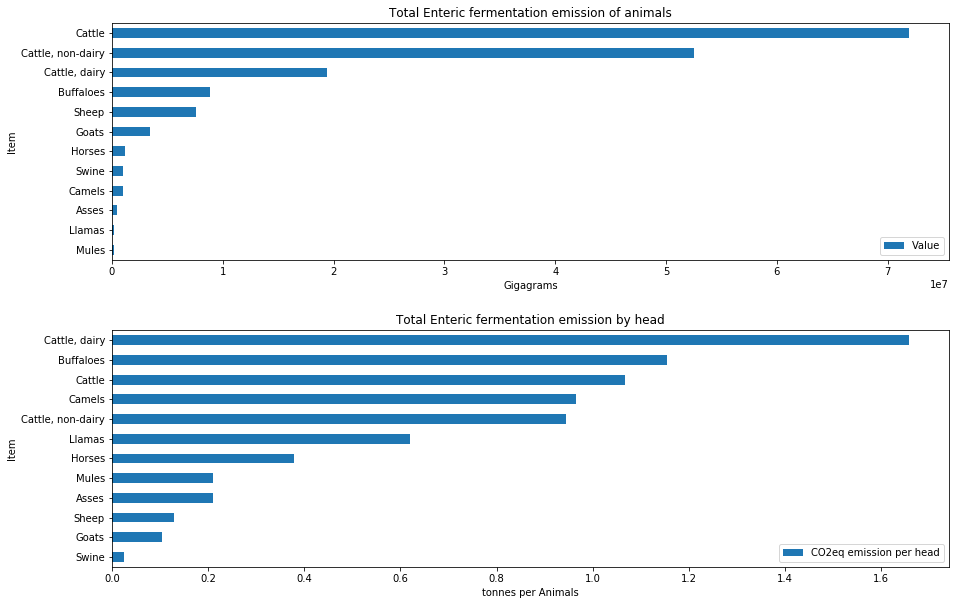

In [14]:
#Grouping stocks count
df_enteric_fermentation_stock_grouped = (
    dfs_enteric_fermentation_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

#Grouping total emissions count
df_enteric_fermentation_emission_grouped = (
    dfs_enteric_fermentation_filtered["emissions"]
    .groupby(["Item"])
    ['Value']
    .sum()
    .reset_index()
)

#Merged to get emissions by head
df_enteric_merged = df_enteric_fermentation_emission_grouped.merge(
    df_enteric_fermentation_stock_grouped,
    on="Item",
    suffixes=("_emission", "_stock")
)

# Convert to tonnes per Animal
df_enteric_merged["CO2eq emission per head"] = df_enteric_merged["Value_emission"] / df_enteric_merged["Value_stock"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_enteric_fermentation_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Enteric fermentation emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_enteric_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Enteric fermentation emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("tonnes per Animals")
axes[1].legend(loc="lower right")

### Manure Soils
The table ‘Manure applied to Soils’ contains the following data:


GHG emissions from manure applied to soils consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) added to agricultural soils by farmers.

In [15]:
df_manure_soils.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values

In [16]:
print(df_manure_soils.isna().any())
print("Array of years will null values :", df_manure_soils[df_manure_soils["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_soils = df_manure_soils[df_manure_soils["Year"]<2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column

In [17]:
df_manure_soils["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure applied)',
       'Implied emission factor for N2O (Manure applied)',
       'Direct emissions (N2O) (Manure applied)',
       'Direct emissions (CO2eq) (Manure applied)',
       'Indirect emissions (N2O) (Manure applied)',
       'Indirect emissions (CO2eq) (Manure applied)',
       'Emissions (N2O) (Manure applied)',
       'Emissions (CO2eq) (Manure applied)'], dtype=object)

Similarly to the previous table, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure applied)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [18]:
#Filter the Element Column
dfs_manure_soils = split_on(
    df_manure_soils[
        df_manure_soils["Element"].isin(["Emissions (CO2eq) (Manure applied)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure applied)": "emissions"
    }
)

print("Stock unit :", dfs_manure_soils.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_soils.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals

In [19]:
print(df_manure_soils["Item"].unique())

Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy', 'Goats', 'Horses',
           'Mules', 'Sheep','Cattle','Chickens', 'Poultry Birds','Buffaloes', 'Ducks',
           'Turkeys', 'Swine', 'Llamas']

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_soils_filtered = DotMap(_dynamic=False)
dfs_manure_soils_filtered["stocks"] = select_on(
    dfs_manure_soils["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_soils_filtered["emissions"] = select_on(
    dfs_manure_soils["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


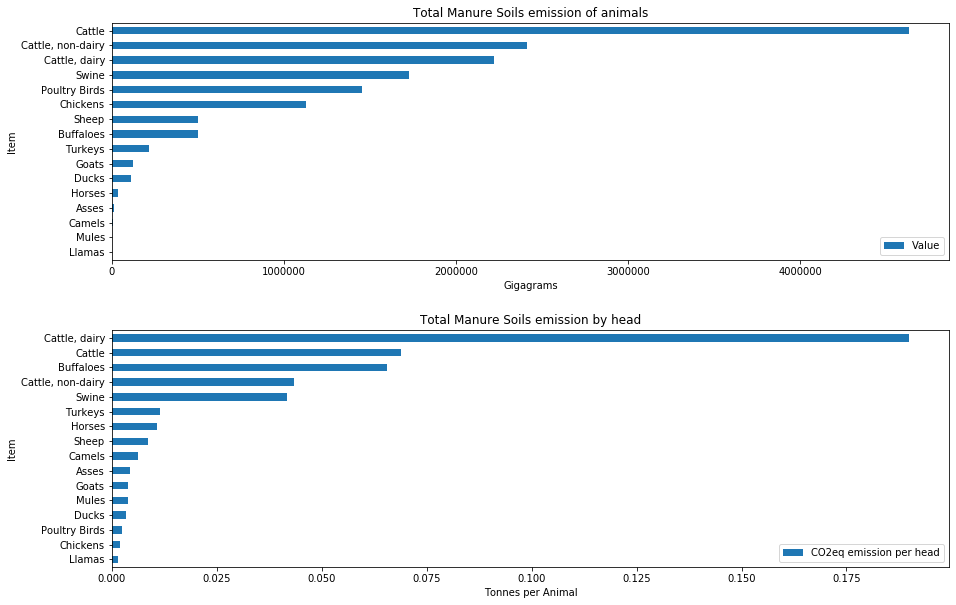

In [20]:
#Grouping stocks count
df_manure_soils_stocks_grouped = (
    dfs_manure_soils_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_soils_emission_grouped = (
    dfs_manure_soils_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_merged = df_manure_soils_emission_grouped.merge(
    df_manure_soils_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per Animal
df_manure_merged["CO2eq emission per head"] = df_manure_merged["Value_emissions"] / df_manure_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_soils_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure Soils emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_manure_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Soils emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Pasture
The table ‘Manure_Pasture’ contains the following data:

GHG emissions from manure left on pastures consisting of direct and indirect nitrous oxide (N2O) emissions from manure nitrogen (N) left on pastures by grazing livestock.

In [21]:
df_manure_pasture.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1961,Gigagrams,0.0953,Calculated data
1,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1962,Gigagrams,0.0625,Calculated data
2,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1963,Gigagrams,0.0734,Calculated data
3,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1964,Gigagrams,0.0843,Calculated data
4,2,Afghanistan,1107,Asses,723602,Indirect emissions (N2O that leaches) (Manure ...,1965,Gigagrams,0.0953,Calculated data


#### Checking for null values

In [22]:
print(df_manure_pasture.isna().any())
print("Array of years will null values :",df_manure_pasture[df_manure_pasture["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_pasture = df_manure_pasture[df_manure_pasture["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element column 

In [23]:
df_manure_pasture["Element"].unique()

array(['Indirect emissions (N2O that leaches) (Manure on pasture)',
       'Indirect emissions (N2O that volatilises) (Manure on pasture)',
       'Manure (N content that leaches) (Manure on pasture)',
       'Manure (N content that volatilises) (Manure on pasture)',
       'Manure (N content) (Manure on pasture)',
       'Implied emission factor for N2O (Manure on pasture)',
       'Direct emissions (N2O) (Manure on pasture)',
       'Direct emissions (CO2eq) (Manure on pasture)',
       'Indirect emissions (N2O) (Manure on pasture)',
       'Indirect emissions (CO2eq) (Manure on pasture)',
       'Emissions (N2O) (Manure on pasture)',
       'Emissions (CO2eq) (Manure on pasture)', 'Stocks'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure on pasture)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [24]:
#Filter the Element Column
dfs_manure_pasture = split_on(
    df_manure_pasture[
        df_manure_pasture["Element"].isin(["Emissions (CO2eq) (Manure on pasture)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure on pasture)": "emissions"
    }
)

print("Stock unit :", dfs_manure_pasture.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_pasture.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals

In [25]:
print(df_manure_pasture["Item"].unique())

Animals = ['Asses', 'Camels', 'Cattle, dairy', 'Cattle, non-dairy','Goats', 'Horses',
           'Mules', 'Sheep', 'Buffaloes', 'Ducks','Turkeys', 'Llamas','Cattle', 'Chickens',
           'Poultry Birds', 'Swine']

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_pasture_filtered = DotMap(_dynamic=False)
dfs_manure_pasture_filtered["stocks"] = select_on(
    dfs_manure_pasture["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_pasture_filtered["emissions"] = select_on(
    dfs_manure_pasture["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Swine, breeding' 'Swine, market' 'Turkeys' 'Llamas' 'All Animals'
 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses' 'Poultry Birds'
 'Sheep and Goats' 'Swine']


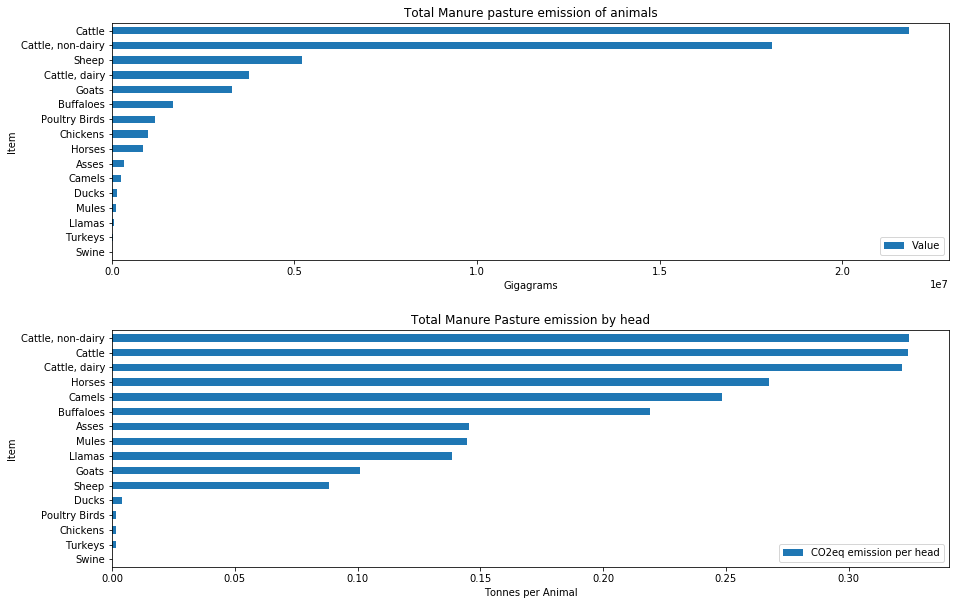

In [26]:
#Grouping stocks count
df_manure_pasture_stocks_grouped = (
    dfs_manure_pasture_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_pasture_emission_grouped = (
    dfs_manure_pasture_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_pasture_merged = df_manure_pasture_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_pasture_merged["CO2eq emission per head"] = df_pasture_merged["Value_emissions"] / df_pasture_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_pasture_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure pasture emission of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_pasture_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure Pasture emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")

### Manure Management
The table ‘Manure_management’ contains the following data:

GHG emissions from manure management consisting of methane and nitrous oxide gases from aerobic and anaerobic manure decomposition processes

In [27]:
df_manure_management.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year,Unit,Value,Flag
0,2,Afghanistan,1107,Asses,5111,Stocks,1961,Head,1300000.0,Official data
1,2,Afghanistan,1107,Asses,5111,Stocks,1962,Head,851850.0,Official data
2,2,Afghanistan,1107,Asses,5111,Stocks,1963,Head,1001112.0,Official data
3,2,Afghanistan,1107,Asses,5111,Stocks,1965,Head,1300000.0,Official data
4,2,Afghanistan,1107,Asses,5111,Stocks,1966,Head,1200000.0,Official data


#### Checking for null values 

In [28]:
print(df_manure_management.isna().any())
print("Array of years will null values :", df_manure_management[df_manure_management["Value"].isna()]["Year"].unique())

#Removing null values(only in predictions)
df_manure_management = df_manure_management[df_manure_management["Year"] < 2030]

Country Code    False
Country         False
Item Code       False
Item            False
Element Code    False
Element         False
Year            False
Unit            False
Value            True
Flag            False
dtype: bool
Array of years will null values : [2030 2050]


#### Element Column

In [29]:
df_manure_management["Element"].unique()

array(['Stocks', 'Manure (N content) (Manure management)',
       'Implied emission factor for CH4 (Manure management)',
       'Implied emission factor for N2O (Manure management)',
       'Emissions (CH4) (Manure management)',
       'Emissions (CO2eq) from CH4 (Manure management)',
       'Direct emissions (N2O) (Manure management)',
       'Indirect emissions (N2O) (Manure management)',
       'Emissions (N2O) (Manure management)',
       'Direct emissions (CO2eq) (Manure management)',
       'Indirect emissions (CO2eq) (Manure management)',
       'Emissions (CO2eq) from N2O (Manure management)',
       'Emissions (CO2eq) (Manure management)'], dtype=object)

Similarly, in the *Element* column we will only be interested in the value of *Stocks* and the value of *Emissions (CO2eq) (Manure management)* which corresponds to the total aggregate of the GHG emission in CO2eq

In [30]:
#Filter the Element Column
dfs_manure_management = split_on(
    df_manure_management[
        df_manure_management["Element"].isin(["Emissions (CO2eq) (Manure management)", "Stocks"])
    ],
    column="Element",
    rename={
        "Stocks": "stocks",
        "Emissions (CO2eq) (Manure management)": "emissions"
    }
)

print("Stock unit :", dfs_manure_management.stocks["Unit"].unique())
print("Emission unit :", dfs_manure_management.emissions["Unit"].unique())

Stock unit : ['Head']
Emission unit : ['Gigagrams']


#### Item column : Removing groups of animals:

In [31]:
print(df_manure_management["Item"].unique())

Animals = ['Asses', 'Buffaloes','Chickens' ,'Camels','Cattle', 'Cattle, dairy', 'Cattle, non-dairy',
           'Ducks','Turkeys','Goats', 'Horses','Llamas', 'Mules','Sheep','Swine','Poultry Birds']

column_filters = {
    "Country" : ["World"],
    "Item" : Animals
}

dfs_manure_management_filtered = DotMap(_dynamic=False)
dfs_manure_management_filtered["stocks"] = select_on(
    dfs_manure_management["stocks"],
    column_filter_dict=column_filters
)
dfs_manure_management_filtered["emissions"] = select_on(
    dfs_manure_management["emissions"],
    column_filter_dict=column_filters
)

['Asses' 'Camels' 'Goats' 'Horses' 'Mules' 'Sheep' 'Buffaloes' 'Ducks'
 'Turkeys' 'Cattle, dairy' 'Cattle, non-dairy' 'Chickens, broilers'
 'Chickens, layers' 'Swine, breeding' 'Swine, market' 'Llamas'
 'All Animals' 'Camels and Llamas' 'Cattle' 'Chickens' 'Mules and Asses'
 'Poultry Birds' 'Sheep and Goats' 'Swine']


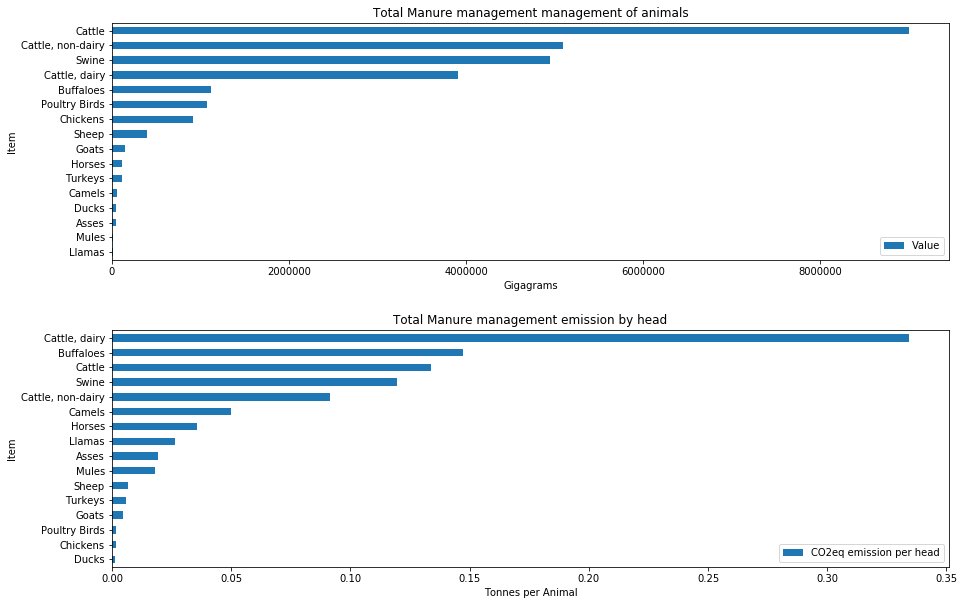

In [32]:
#Grouping stocks count
df_manure_management_stocks_grouped = (
    dfs_manure_management_filtered["stocks"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_manure_management_emission_grouped = (
    dfs_manure_management_filtered["emissions"]
    .groupby("Item")
    ["Value"]
    .sum()
    .reset_index()
)

df_management_merged = df_manure_management_emission_grouped.merge(
    df_manure_pasture_stocks_grouped,
    on="Item",
    suffixes=("_emissions", "_stocks")
)

# Convert to tonnes per animals
df_management_merged["CO2eq emission per head"] = df_management_merged["Value_emissions"] / df_management_merged["Value_stocks"] * 1000

fig, axes = plt.subplots(2, 1, figsize=(15,10))
fig.subplots_adjust(hspace=0.3)

df_manure_management_emission_grouped.sort_values("Value").plot.barh(
    "Item",
    title="Total Manure management management of animals",
    ax=axes[0]
)
axes[0].set_xlabel("Gigagrams")
axes[0].legend(loc="lower right")

df_management_merged.sort_values("CO2eq emission per head").plot.barh(
    x="Item",
    y="CO2eq emission per head",
    title="Total Manure management emission by head",
    ax=axes[1]
)
axes[1].set_xlabel("Tonnes per Animal")
axes[1].legend(loc="lower right")


After analyzing the impact of different livestock species we chose to only study the ones that have the most impact which are the following:

**'Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Cattle', 'Chickens', 'Poultry Birds'**

In [33]:
Animals = ['Cattle, dairy', 'Cattle, non-dairy', 'Swine', 'Cattle', 'Chickens', 'Poultry Birds']

In [34]:
#Filtering all tables to keep only the selected animals
dfs_stock = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.stocks,
        "manure_management": dfs_manure_management.stocks,
        "manure_pasture": dfs_manure_pasture.stocks,
        "manure_soils": dfs_manure_soils.stocks
    },
    _dynamic=False
)

dfs_emissions = DotMap(
    {
        "enteric_fermentation": dfs_enteric_fermentation.emissions,
        "manure_management": dfs_manure_management.emissions,
        "manure_pasture": dfs_manure_pasture.emissions,
        "manure_soils": dfs_manure_soils.emissions
    },
    _dynamic=False
)

column_filters = {"Item": Animals}
for name, df in dfs_stock.items():
    dfs_stock[name] = select_on(df, column_filter_dict=column_filters)
for name, df in dfs_emissions.items():
    dfs_emissions[name] = select_on(df, column_filter_dict=column_filters)

To focus on a good range of years for our analysis we compute for each year the number of countries where there is available data of livestocks.

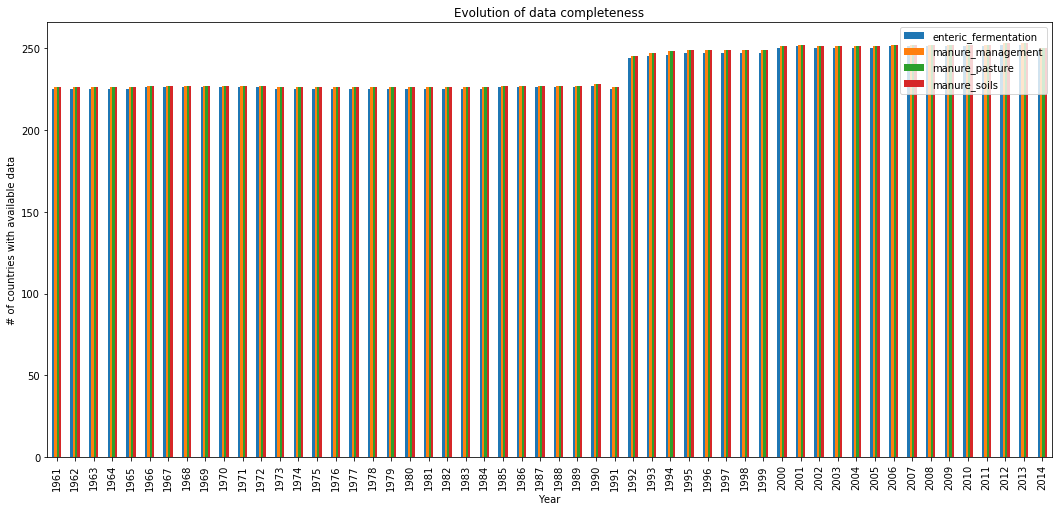

In [35]:
plot_completeness_histogram(dfs_stock, figsize=(18, 8), agg_on="Country Code")

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [36]:
df = dfs_stock.enteric_fermentation
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Country"].unique()) - set(df_before["Country"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Central Asia',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require care in the visualization: the choice of countries to use will most likely be done on a per year basis.

## Computed emissions data

In [37]:
# load base info, drop redundant year code column
df_env_emission_intensity = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Environment_Emissions_intensities_E_All_Data_(Normalized).csv",
    df_flags
).drop("Year Code", axis="columns")

#Remove aggreagated data
df_env_emission_intensity = remove_country_group(df_env_emission_intensity, df_area_groups)

# Split on the Element column
dfs_env_em_intensity = split_on(
    df_env_emission_intensity, "Element",
    drop="Element Code",
    rename=to_snakecase
)
del df_env_emission_intensity
    
for table_name, df in dfs_env_em_intensity.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    if table_name == "emissions_intensity":
        print("  - Available products:", end="\n      ")
        for k, prod in enumerate(df['Item'].unique()):
            print("%-23s" % prod, end="\n      " if k % 3 == 2 else "\t\t")
        print()
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table emissions_intensity
  - Units: kg CO2eq/kg product
  - Available products:
      Cereals excluding rice 		Rice, paddy            		Meat, cattle           
      Milk, whole fresh cow  		Meat, goat             		Milk, whole fresh goat 
      Meat, sheep            		Milk, whole fresh sheep		Milk, whole fresh camel
      Meat, chicken          		Eggs, hen, in shell    		Milk, whole fresh buffalo
      Meat, pig              		Meat, buffalo          		
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
606,2,Afghanistan,1020,"Milk, whole fresh goat",1998,kg CO2eq/kg product,4.6209,Calculated data
203292,243,Wallis and Futuna Islands,1017,"Meat, goat",1992,kg CO2eq/kg product,101.5270,Calculated data
53756,250,Democratic Republic of the Congo,867,"Meat, cattle",1984,kg CO2eq/kg product,63.9688,Calculated data
81802,175,Guinea-Bissau,1718,Cereals excluding rice,1984,kg CO2eq/kg product,0.1149,Calculated data
202998,243,Wallis and Futuna Islands,867,"Meat, cattle",1968,kg CO2eq/kg product,34.4368,Calculated data
23149,20,Botswana,1062,"Eggs, hen, in shell",1968,kg CO2eq/kg product,3.6305,Calculated data
145398,169,Paraguay,1718,Cereals excluding rice,2005,kg CO2eq/kg product,0.1669,Calculated data
28530,233,Burkina Faso,1130,"Milk, whole fresh camel",2007,kg CO2eq/kg product,11.2482,Calculated data
53541,250,Democratic Republic of the Congo,1718,Cereals excluding rice,1985,kg CO2eq/kg product,0.1836,Calculated data
145795,169,Paraguay,1017,"Meat, goat",1970,kg CO2eq/kg product,72.1777,Calculated data




Table emissions_(co2eq)
  - Units: gigagrams
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
49575,49,Cuba,882,"Milk, whole fresh cow",1998,gigagrams,1151.1532,Calculated data
23597,21,Brazil,27,"Rice, paddy",1985,gigagrams,8052.1220,Calculated data
144791,168,Papua New Guinea,1020,"Milk, whole fresh goat",2000,gigagrams,0.2122,Calculated data
200381,155,Vanuatu,1017,"Meat, goat",2013,gigagrams,5.4127,Calculated data
194735,229,United Kingdom,1058,"Meat, chicken",2005,gigagrams,427.7595,Calculated data
77465,86,Grenada,1062,"Eggs, hen, in shell",2009,gigagrams,0.8734,Calculated data
57921,56,Dominican Republic,1062,"Eggs, hen, in shell",1978,gigagrams,16.8649,Calculated data
110710,256,Luxembourg,1062,"Eggs, hen, in shell",2008,gigagrams,0.7145,Calculated data
10528,52,Azerbaijan,1062,"Eggs, hen, in shell",1998,gigagrams,22.8457,Calculated data
63102,178,Eritrea,1062,"Eggs, hen, in shell",1993,gigagrams,5.6396,Calculated data




Table production
  - Units: tonnes
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Year,Unit,Value,Flag
89304,100,India,977,"Meat, sheep",1985,tonnes,175200.0,Calculated data
193472,225,United Arab Emirates,1017,"Meat, goat",1963,tonnes,960.0,Calculated data
309619,126,Lithuania,1035,"Meat, pig",2007,tonnes,99288.0,Official data
235683,250,Democratic Republic of the Congo,1718,Cereals excluding rice,1975,tonnes,551221.0,"Aggregate, may include official, semi-official..."
33095,32,Cameroon,1020,"Milk, whole fresh goat",1979,tonnes,13000.0,Calculated data
346315,223,Turkey,977,"Meat, sheep",1987,tonnes,310000.0,Unofficial figure
331769,116,Democratic People's Republic of Korea,882,"Milk, whole fresh cow",1961,tonnes,2100.0,FAO estimate
112444,130,Malawi,1017,"Meat, goat",1972,tonnes,2268.0,Calculated data
330306,35,Cabo Verde,1058,"Meat, chicken",1966,tonnes,45.0,FAO estimate
129568,148,Nauru,1035,"Meat, pig",1985,tonnes,48.0,Calculated data


[]

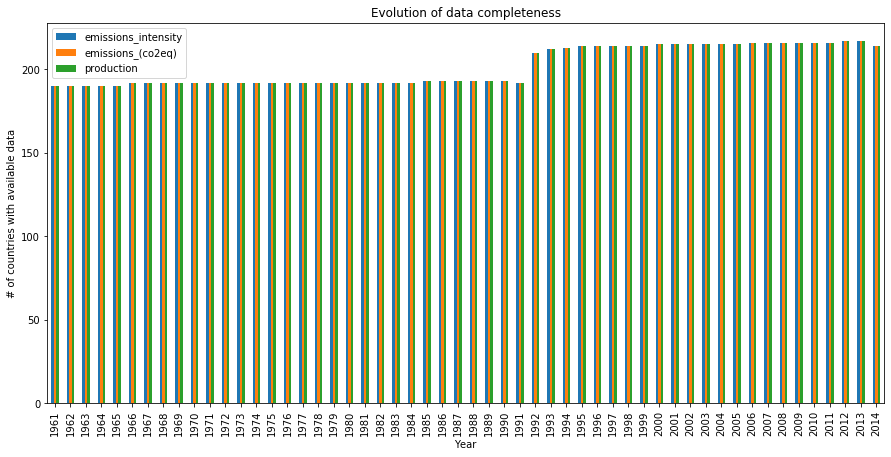

In [38]:
plot_completeness_histogram(dfs_env_em_intensity, figsize=(15, 7))
plt.plot()

The above histogram showing how complete the data are (number of country with data as a function of time) shows that the data are quite complete. Somme countries seems to have been added in 1992, let's find those.

In [39]:
df = dfs_env_em_intensity.production
df_before = df[ df["Year"] == 1991]
df_after = df[ df["Year"] == 1992]

set(df_after["Area"].unique()) - set(df_before["Area"].unique())

{'Armenia',
 'Azerbaijan',
 'Belarus',
 'Bosnia and Herzegovina',
 'Croatia',
 'Estonia',
 'Georgia',
 'Kazakhstan',
 'Kyrgyzstan',
 'Latvia',
 'Lithuania',
 'Republic of Moldova',
 'Russian Federation',
 'Serbia and Montenegro',
 'Slovenia',
 'Tajikistan',
 'The former Yugoslav Republic of Macedonia',
 'Turkmenistan',
 'Ukraine',
 'Uzbekistan'}

This is due to the dilution of the URSS. This will require special handling in the analysis and visualization: the choice of countries to use will most likely be done on a per year basis.

## Productions

In [40]:
# Load, remove duplicate column "year code"
df_prod_animals = load_df(
    DATA / "global-food-agriculture-statistics/raw_files/Production_LivestockPrimary_E_All_Data_(Normalized).csv",
    df_flags
).drop(columns="Year Code")


#remove aggregated data
df_prod_animals = remove_country_group(df_prod_animals, df_area_groups)

# Harmonise units
## 1000 Head -> Head
unit_filter = df_prod_animals["Unit"] == "1000 Head"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "Head"

## 1000 No -> No
unit_filter = df_prod_animals["Unit"] == "1000 No"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].multiply(1000)
df_prod_animals.loc[unit_filter, "Unit"] = "No"

## 100mg/An 0.1g/An -> g/An
unit_filter = df_prod_animals["Unit"].isin(["100mg/An", "0.1g/An"])
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "g/An"

## hg/An -> kg/An
unit_filter = df_prod_animals["Unit"] == "hg/An"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg/An"

## hg -> kg
unit_filter = df_prod_animals["Unit"] == "hg"
df_prod_animals.loc[unit_filter, "Value"] = df_prod_animals[unit_filter]["Value"].div(10)
df_prod_animals.loc[unit_filter, "Unit"] = "kg"

# Split according to Element column
dfs_prod_animals = split_on(
    df_prod_animals,
    "Element",
    rename=to_snakecase
)


for table_name, df in dfs_prod_animals.items():
    print(f"\n\nTable {table_name}")
    print(f"  - Units: {', '.join(df['Unit'].unique())}")
    print("  - Sample of 10 values:")
    display(df.sample(10))



Table laying
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
813211,96,"China, Hong Kong SAR",1783,Eggs Primary,5313,1994,Head,324000.0,"Aggregate, may include official, semi-official..."
36874,51,Czechoslovakia,1062,"Eggs, hen, in shell",5313,1967,Head,13700000.0,FAO estimate
12462,53,Benin,1062,"Eggs, hen, in shell",5313,1998,Head,1560000.0,FAO estimate
145804,251,Zambia,1062,"Eggs, hen, in shell",5313,1975,Head,6850000.0,FAO estimate
862176,124,Libya,1783,Eggs Primary,5313,1980,Head,2100000.0,"Aggregate, may include official, semi-official..."
912343,212,Syrian Arab Republic,1783,Eggs Primary,5313,1964,Head,2250000.0,"Aggregate, may include official, semi-official..."
900298,194,Saudi Arabia,1783,Eggs Primary,5313,1963,Head,185000.0,"Aggregate, may include official, semi-official..."
102360,168,Papua New Guinea,1062,"Eggs, hen, in shell",5313,1970,Head,450000.0,FAO estimate
914509,176,Timor-Leste,1783,Eggs Primary,5313,1986,Head,115000.0,"Aggregate, may include official, semi-official..."
70590,109,Jamaica,1062,"Eggs, hen, in shell",5313,2006,Head,1450000.0,FAO estimate




Table production
  - Units: tonnes, No, Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
198419,106,Italy,987,"Wool, greasy",5510,1984,tonnes,12752.0,Official data
181165,67,Finland,1097,"Meat, horse",5510,2003,tonnes,193.0,Official data
901124,195,Senegal,1783,Eggs Primary,5510,1982,tonnes,7040.0,"Aggregate, may include official, semi-official..."
42762,59,Egypt,1012,"Meat indigenous, sheep",5322,1993,Head,2322753.0,FAO estimate
786291,8,Antigua and Barbuda,1807,Sheep and Goat Meat,5510,1999,tonnes,145.0,"Aggregate, may include official, semi-official..."
184244,70,French Polynesia,882,"Milk, whole fresh cow",5510,1979,tonnes,1850.0,Official data
228109,179,Qatar,1058,"Meat, chicken",5510,1996,tonnes,4111.0,Official data
779687,190,Saint Pierre and Miquelon,1055,"Meat indigenous, pig",5510,2002,tonnes,NaN,Data not available
241148,210,Sweden,1094,"Meat indigenous, chicken",5323,1973,Head,35031000.0,Official data
907309,203,Spain,1770,"Meat indigenous, total",5510,1974,tonnes,1944146.0,"Aggregate, may include official, semi-official..."




Table producing_animals/slaughtered
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
736909,88,Guam,947,"Meat, buffalo",5320,1991,Head,5.0,FAO data based on imputation methodology
845524,91,Guyana,1807,Sheep and Goat Meat,5320,1990,Head,76500.0,"Aggregate, may include official, semi-official..."
46155,62,Ethiopia PDR,1058,"Meat, chicken",5321,1964,Head,62209000.0,FAO estimate
791382,16,Bangladesh,1807,Sheep and Goat Meat,5320,1988,Head,9338000.0,"Aggregate, may include official, semi-official..."
817145,45,Comoros,1808,"Meat, Poultry",5321,2007,Head,680000.0,"Aggregate, may include official, semi-official..."
316967,33,Canada,1035,"Meat, pig",5320,2014,Head,20418200.0,Calculated data
780086,198,Slovenia,1069,"Meat, duck",5321,1993,Head,NaN,Data not available
93231,147,Namibia,995,"Skins, sheep, fresh",5320,1975,Head,900000.0,FAO estimate
544103,190,Saint Pierre and Miquelon,1058,"Meat, chicken",5321,1966,Head,0.0,Calculated data
153005,11,Austria,1141,"Meat, rabbit",5321,1989,Head,540000.0,Official data




Table milk_animals
  - Units: Head
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
36001,49,Cuba,1020,"Milk, whole fresh goat",5318,2002,Head,8000.0,FAO estimate
822429,167,Czechia,1780,"Milk,Total",5318,1999,Head,613299.0,"Aggregate, may include official, semi-official..."
50192,70,French Polynesia,882,"Milk, whole fresh cow",5318,2011,Head,500.0,FAO estimate
161106,27,Bulgaria,882,"Milk, whole fresh cow",5318,1968,Head,519366.0,Official data
10277,16,Bangladesh,882,"Milk, whole fresh cow",5318,1995,Head,3790000.0,FAO estimate
73131,114,Kenya,982,"Milk, whole fresh sheep",5318,1961,Head,860000.0,FAO estimate
782435,2,Afghanistan,1780,"Milk,Total",5318,1962,Head,7672000.0,"Aggregate, may include official, semi-official..."
233671,186,Serbia and Montenegro,882,"Milk, whole fresh cow",5318,2000,Head,848000.0,Official data
3155,4,Algeria,1020,"Milk, whole fresh goat",5318,1989,Head,1227600.0,FAO estimate
893353,146,Republic of Moldova,1780,"Milk,Total",5318,2001,Head,993209.0,"Aggregate, may include official, semi-official..."




Table prod_popultn
  - Units: Head, No
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
248934,223,Turkey,987,"Wool, greasy",5319,1968,Head,26909760.0,Official data
718483,249,Yemen,987,"Wool, greasy",5319,1983,Head,3379696.0,Unofficial figure
781839,251,Zambia,1182,"Honey, natural",5314,1997,No,NaN,Data not available
163898,33,Canada,987,"Wool, greasy",5319,1978,Head,306400.0,Official data
781787,237,Viet Nam,1185,"Silk-worm cocoons, reelable",5319,2001,Head,NaN,Data not available
154554,16,Bangladesh,987,"Wool, greasy",5319,1979,Head,1061000.0,Official data
773051,79,Germany,1182,"Honey, natural",5314,2003,No,NaN,Data not available
244175,212,Syrian Arab Republic,1182,"Honey, natural",5314,2000,No,0.0,Official data
771015,49,Cuba,1182,"Honey, natural",5314,1993,No,NaN,Data not available
212633,28,Myanmar,987,"Wool, greasy",5319,1986,Head,317000.0,Official data




Table yield
  - Units: g/An, kg/An, kg
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
543434,190,Saint Pierre and Miquelon,1062,"Eggs, hen, in shell",5410,1994,g/An,2800.0,Calculated data
292952,18,Bhutan,1780,"Milk,Total",5420,1994,kg/An,257.6,Calculated data
376625,66,Fiji,1783,Eggs Primary,5410,1970,g/An,4064.2,Calculated data
373079,62,Ethiopia PDR,995,"Skins, sheep, fresh",5420,1963,kg/An,1.8,Calculated data
573026,206,Sudan (former),982,"Milk, whole fresh sheep",5420,1985,kg/An,47.1,Calculated data
586226,216,Thailand,1780,"Milk,Total",5420,1969,kg/An,1181.8,Calculated data
587075,176,Timor-Leste,919,"Hides, cattle, fresh",5420,1990,kg/An,20.0,Calculated data
577948,210,Sweden,882,"Milk, whole fresh cow",5420,1983,kg/An,5620.5,Calculated data
624632,249,Yemen,1020,"Milk, whole fresh goat",5420,2003,kg/An,28.0,Calculated data
574824,207,Suriname,882,"Milk, whole fresh cow",5420,1999,kg/An,1911.8,Calculated data




Table yield/carcass_weight
  - Units: kg/An, g/An
  - Sample of 10 values:


,Area Code,Area,Item Code,Item,Element Code,Year,Unit,Value,Flag
440244,83,Kiribati,1808,"Meat, Poultry",5424,1970,g/An,850.0,Calculated data
601774,226,Uganda,1806,Beef and Buffalo Meat,5417,1988,kg/An,150.0,Calculated data
477239,142,Montserrat,1094,"Meat indigenous, chicken",5424,1994,g/An,1200.0,Calculated data
580627,212,Syrian Arab Republic,1084,"Meat indigenous, bird nes",5424,2011,g/An,400.0,Calculated data
298398,20,Botswana,1808,"Meat, Poultry",5424,2006,g/An,800.0,Calculated data
420790,102,Iran (Islamic Republic of),1127,"Meat, camel",5417,2011,kg/An,205.7,Calculated data
363241,58,Ecuador,977,"Meat, sheep",5417,1969,kg/An,14.0,Calculated data
308992,29,Burundi,1094,"Meat indigenous, chicken",5424,2004,g/An,900.0,Calculated data
552339,195,Senegal,867,"Meat, cattle",5417,2013,kg/An,163.5,Calculated data
417679,101,Indonesia,1120,"Meat indigenous, horse",5417,1981,kg/An,159.3,Calculated data


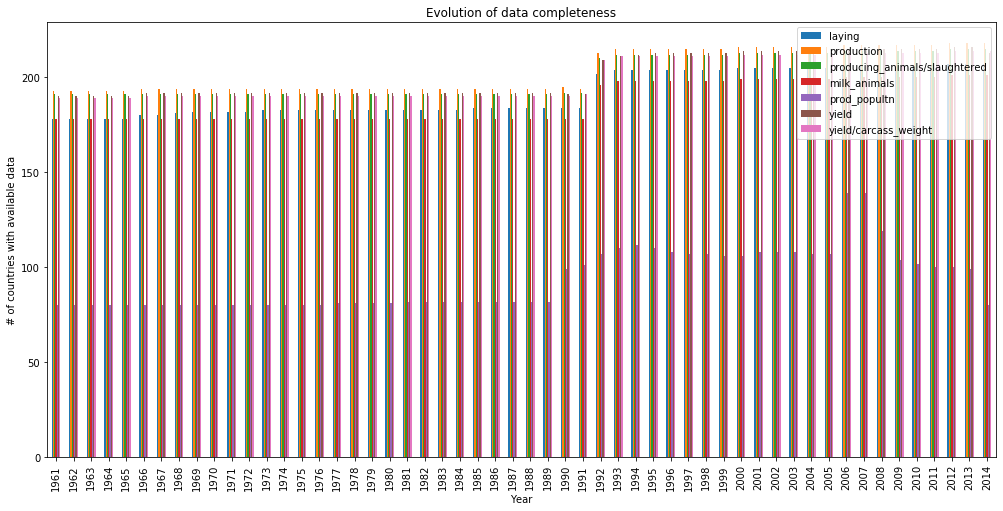

In [41]:
plot_completeness_histogram(dfs_prod_animals, figsize=(17,8))

The above bar plot shows that the `prod_popultn` Table has a lot of missing countries. Given the data it holds, namely the production of `['Wool, greasy', 'Honey, natural', 'Beeswax', 'Silk-worm cocoons, reelable', 'Hair, horse']`, this is not a problem.

The tables we are mostly interested in are `production`, `yield` and `producing_animals/slaughtered`, so we will have to consider only contries at least in those three tables.

## Trade data

# Livestock food estimate

Using [http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf](http://www.agronext.iastate.edu/immag/pubs/manure-prod-char-d384-2.pdf), we can try to estimate the food consuption of some livestock

## Beef

Using the above reference, section 4 for the equations, Table 2 for variable definitons, and Tables 3a and 3b for assumption, we get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    \mathit{DMI}_\mathit{ration}
                    \times \mathit{DOF}_\mathit{ration}
                    \times \left(1 - \frac{\mathit{DMD}_\mathit{ration}}{100}\right)
                   \right)
                    +
                   \sum_{ration} \left(
                    \mathit{DOF}_\mathit{ration}
                    \times 20.3 \times 0.06
                    \times \mathit{BW}_\mathit{AVG}
                  \right)
\end{align}
$$
where:
+ $\mathit{DM}$: total dry matter excretion
+ $\mathit{DMI}$: Dry Matter Ingestion, for a given ration
+ $\mathit{DOF}$: Day On Feed, number of days a ration lasts
+ $\mathit{DMD}$: Dry Matter Digestibility
+ $\mathit{BW}_\mathit{AVG}$: Body Weight average for the duration of the ration

Given the second part handles the dry content of urine (6%) and since the average body weigth is 471kg, the factor 20.3 is highly dubious - a cattle does not excrete 20 times its mass in urine a day.

After research, we found cattle produce a bit more than 20L gallons a day of urine, and $\frac{471~\mathit{kg}}{20.3 ~ \mathit{kg} . L^{-1}} = 23.2~L$. We therefore correct the above equation to *divide* the body weigth by 20.3.

We first formally split all multi-days ration into 1 day rations, so that $\mathit{DOF} := 1$. Then with Table 3b we estimate the dry matter digestibility to be 80%, hence $\mathit{DMD} = 80$ in the equation. Finally, from Table 3b, $\mathit{DMI} = 0.02 \mathit{BW}_\mathit{AVG}$.

We get:

$$
\begin{align}
    \mathit{DM} &= \sum_{ration} \left(
                    0.2 \times 0.02 \times \mathit{BW}_\mathit{AVG}
                    +
                    \frac{0.06}{20.3} \mathit{BW}_\mathit{AVG}
                  \right) \\
    \mathit{DM} &= 6.956 \times 10^{-3} \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_\mathit{ration} \mathit{BW}_\mathit{AVG} &= 3.383 \times 10^2 \times \mathit{DM}
\end{align}
$$

Injecting the relationship between $\mathit{DM}$ and $\mathit{BW}$, we get:

$$
\begin{align}
    \sum_{ration} \mathit{DMI} &= 0.02 \times \sum_{ration} \mathit{BW}_\mathit{AVG} \\
    \sum_{ration} \mathit{DMI} &= 6.7667 \times \mathit{DM}
\end{align}
$$

This holds for the whole life of the cattle. Inputing the water content of 92% for manure, we finally get (keeping more precision digit from previous calculations):

$$
    \sum_{ration} \mathit{DMI} = 0.54133 \times \mathit{Manure}
$$

In [42]:
def cattle_consumption_from_manure(manure):
    """
    Yield the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.54133

## Dairy cattle

The above reference, section 5 yields:
$$
    \mathit{DM}_\mathit{per~day} = 0.350 \times \mathit{DMI} + 1.017
$$

Including the milk production is a bit more precise according to the reference, but requires estimating the content of true protein on our end:

$$
    \mathit{DM}_\mathit{per~day} =
        0.135 \times \mathit{Milk}
        + 0.004 \times \mathit{BW}
        + 0.004 \times \mathit{DIM}
        + 118.370 \times \mathit{MTP}
        - 2.456
$$

where:
+ $\mathit{MTP}$ is the Milk True Protein in g / g of milk / day

The average body weigth is from the same document 624kg. The moisture content of manure is reported to be 87%.

In [43]:
# Whenever possible, constant and estimated values have been aggregated
def dairy_cattle_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the food consumption in kg of dry matter of dairy cattle
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return ((0.13 * manure) - 1.017 * animal_count * days) / 0.35

def dairy_cattle_consumption_from_manure_milk(manure, animal_count, milk, milk_true_prot, days=365.25):
    """
    Yields the food consumption in kg of dry matter of non-dairy cattle
    from their production of manure and milk
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (0.17 * manure - 0.135 * milk - 118.370 * milk_true_prot - 0.004 * animal_count * days) / 0.004

## Poultry
This includes Broilers, Turkeys and ducks. The conversion from section 7 is strait-forward

In [44]:
def broiler_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of broiler
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3116

def turkey_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of turkey, Toms and Hens
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.2521

def duck_consumption_from_manure(manure):
    """
    Yields the food consumption in kg of dry matter of duck
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return manure * 0.3063

## Poultry (laying hen)

Using the equation from 8.3.1 and injecting all the estimates from Table 11, we get a simple affine function. Manure is estimated as 75% moisture.

$$
    \mathit{DM}_\mathit{per~day} = \mathit{DMI} - 0.85 \times \mathit{DMI}
    \times \frac{
        140 + 53 \times \mathit{Egg}_\mathit{prod}
    }{
        \mathit{KCAL}_i
    }
    - 0.3319 \times \mathit{Egg}_{prod} \times \mathit{Egg}_\mathit{wt}
$$

Table 11 gives
+ $\mathit{Egg}_\mathit{prod} = 0.8$
+ $\mathit{Egg}_\mathit{wt} = 61.5 g$
+ $\mathit{KCAL}_i = 281 \mathit{KCal}$

hence:

$$
    \mathit{DM}_\mathit{per~day} = 0.350889 \times \mathit{DMI} - 16.32948
$$

Assuming a $75%$ moisture content and summing over the year on all animals, we get:

$$
    \mathit{DMI}_\mathit{tot} = \frac{0.25 \mathit{manure} + 16.32948 \times \mathit{days} \times \mathit{\# animals}}{0.350889}
$$

In [45]:
def laying_consumption_from_manure(manure, animal_count, days=365.25):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return (manure / 4 + 16.3295 * days * animal_count) / 0.3509

## Swine

We differenciate between nursery pig (5 - 20kg) and grow-finishing pig (20 - 120 kg).
Using section 9.3.1, we get:

$$
    \mathit{DM} = \mathit{DMI} * \frac{100 - DMD}{10000}
                    + 0.025 \times \mathit{DOF} \times \left(
                        20 \mathit{BW}_\mathit{AVG} + 2100
                      \right)
$$

Inputing the assumptions from Table 18b:
+ $\mathit{DMD} = 82$
+ $\mathit{DOF} = 120$
+ $\mathit{DMI} = 0.034 \mathit{BW}$

Solving first for $\mathit{BW}$ and then going back to $\mathit{DMI}$, we get:

$$
    \mathit{DMI} = 0.034 \times \frac{\mathit{DM} - 6300}{60}
$$

For nursery swine, equation 9.4.1 with assumptions from Table 18b yields simply:

$$
    \mathit{DMI} = \frac{1000}{72} \mathit{DM}
$$

From Table 18a, we hestimate that the manure is $(120 - 56) / 120 = 53\%$ moisture

In [46]:
def swine_consumption_from_manure(manure, swine_count):
    """
    Yields the yearly food consumption in kg of dry matter of laying hen
    from their production of manure and the total number of swine
    
    Args:
        manure: number of pandas.Series - the manure production, in a year
    
    Returns:
        Series or number (same type as input): the consumption of dry food in kg
    """
    return 0.034 * (manure * 56 / 120 - 6300 * swine_count) / 60

def nursery_swine_consumption_from_manure(manure):
    return 1000 / 72 * manure